In [1]:
import matplotlib.pyplot as plt
from train2 import *
import numpy as np
import jax.numpy as jnp
import jax

2022-12-15 19:00:13.218939: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-15 19:00:13.747896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/home/katie/.mujoco/mujoco210/bin:/home/katie/.mujoco/mjpro150/bin:/usr/lib/nvidia
2022-12-15 19:00:13.747993: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/home/katie/.mujoco/mujoco210/bin:/home/katie/.mujoco/mjpro150/bin:/usr/lib/nvidia
2022-12-15 19:00:13.748002: W tensorflow/compiler/tf2tensorrt/utils/py_utils

In [2]:
! CUDA_VISIBLE_DEVICES=0
rotations = np.array([0, 15, 30, 45, 60, 75]).astype(int)
train_ds, test_ds = get_datasets(rotations)
state = train(train_ds, test_ds, rotations)

2022-12-15 19:00:24.141037: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2130] Execution of replica 0 failed: INTERNAL: CustomCall failed: jaxlib/cuda/cuda_prng_kernels.cc:32: operation cudaGetLastError() failed: out of memory

KeyboardInterrupt



In [3]:
policy_avg_returns = []
robust_policy_avg_returns = []
for rotation in rotations:
    test_loss, policy_avg_return, robust_policy_avg_return = evaluate_model(state, test_ds['image'+str(rotation)],
                                          test_ds['label'])
    policy_avg_returns.append(float(policy_avg_return))
    robust_policy_avg_returns.append(float(robust_policy_avg_return))
nonadaptive_robust_policy_avg_returns = np.zeros(shape=len(rotations))

Text(0, 0.5, 'Regret')

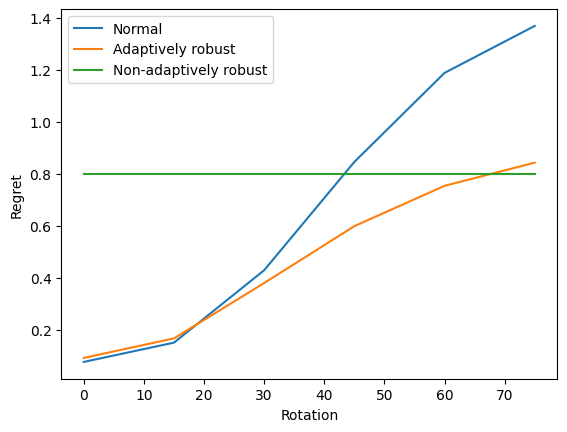

In [39]:
plt.plot(rotations, 0.8-np.array(policy_avg_returns), label = "Normal")
plt.plot(rotations, 0.8-np.array(robust_policy_avg_returns), label = "Adaptively robust")
plt.plot(rotations, 0.8-np.array(nonadaptive_robust_policy_avg_returns), label = "Non-adaptively robust")
plt.legend()
plt.xlabel("Rotation")
plt.ylabel("Regret")

In [19]:
import scipy

digits = [_ for _ in range(10)]

all_best_actions = []
all_best_robust_actions = []
for i in range(len(rotations)):
    rotation = rotations[i]
    qs, z = get_model_outputs(state, test_ds['image'+str(rotation)], test_ds['label'])
    
    best_actions = jnp.argmax(jnp.mean(qs, axis=0), axis=1)
    best_robust_actions = jnp.argmax(jnp.min(qs, axis=0), axis=1)
    
    digit_best_actions = []
    digit_best_robust_actions = []
    for digit in digits:
        digit_best_action = scipy.stats.mode(jnp.asarray(best_actions)[np.where(test_ds['label']==digit)]).mode[0]
        digit_best_robust_action = scipy.stats.mode(jnp.asarray(best_robust_actions)[np.where(test_ds['label']==digit)]).mode[0]
        digit_best_actions.append(digit_best_action)
        digit_best_robust_actions.append(digit_best_robust_action)
        
    all_best_actions.append(digit_best_actions)
    all_best_robust_actions.append(digit_best_robust_actions)

all_best_actions = np.array(all_best_actions)
all_best_robust_actions = np.array(all_best_robust_actions)

    

/tmp/ipykernel_2433297/1291938509.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  digit_best_action = scipy.stats.mode(jnp.asarray(best_actions)[np.where(test_ds['label']==digit)]).mode[0]
/tmp/ipykernel_2433297/1291938509.py:18: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid

Text(0.5, 1.0, 'Normal')

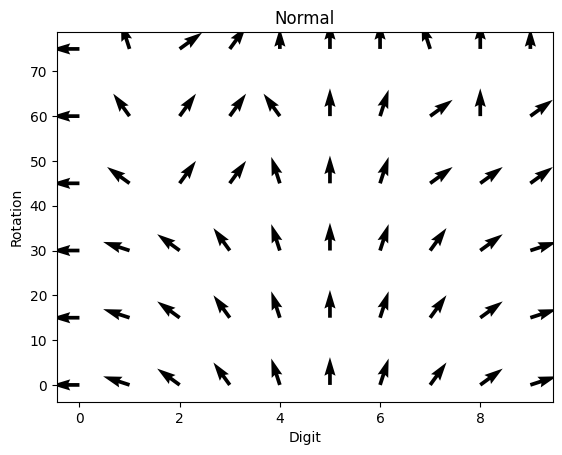

In [40]:
discretized_a1s = (np.expand_dims(np.array([_ for _ in range(10)]), axis=1)*np.ones([10, 5])).flatten()
discretized_a2s = (np.expand_dims(np.array([0.2*_ for _ in range(5)]), axis=0)*np.ones([10, 5])).flatten()

theta = (discretized_a1s[all_best_actions]-5.0)/5*(np.pi/2)
theta = np.transpose(theta)
U = np.sin(theta)* np.transpose(discretized_a2s[all_best_actions])
V = np.cos(theta)* np.transpose(discretized_a2s[all_best_actions])
X,Y = np.meshgrid(rotations, digits)
plt.quiver(Y,X,U,V)
plt.xlabel("Digit")
plt.ylabel("Rotation")
plt.title("Normal")  

Text(0.5, 1.0, 'Adaptively Robust')

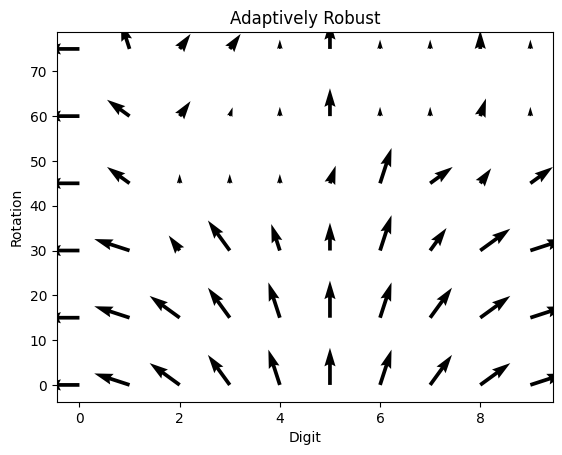

In [41]:
theta = (discretized_a1s[all_best_robust_actions]-5.0)/5*(np.pi/2)
theta = np.transpose(theta)
U = np.sin(theta)* np.transpose(discretized_a2s[all_best_robust_actions])
V = np.cos(theta)* np.transpose(discretized_a2s[all_best_robust_actions])
X,Y = np.meshgrid(rotations, digits)
plt.quiver(Y,X,U,V)
plt.xlabel("Digit")
plt.ylabel("Rotation")
plt.title("Adaptively Robust")  

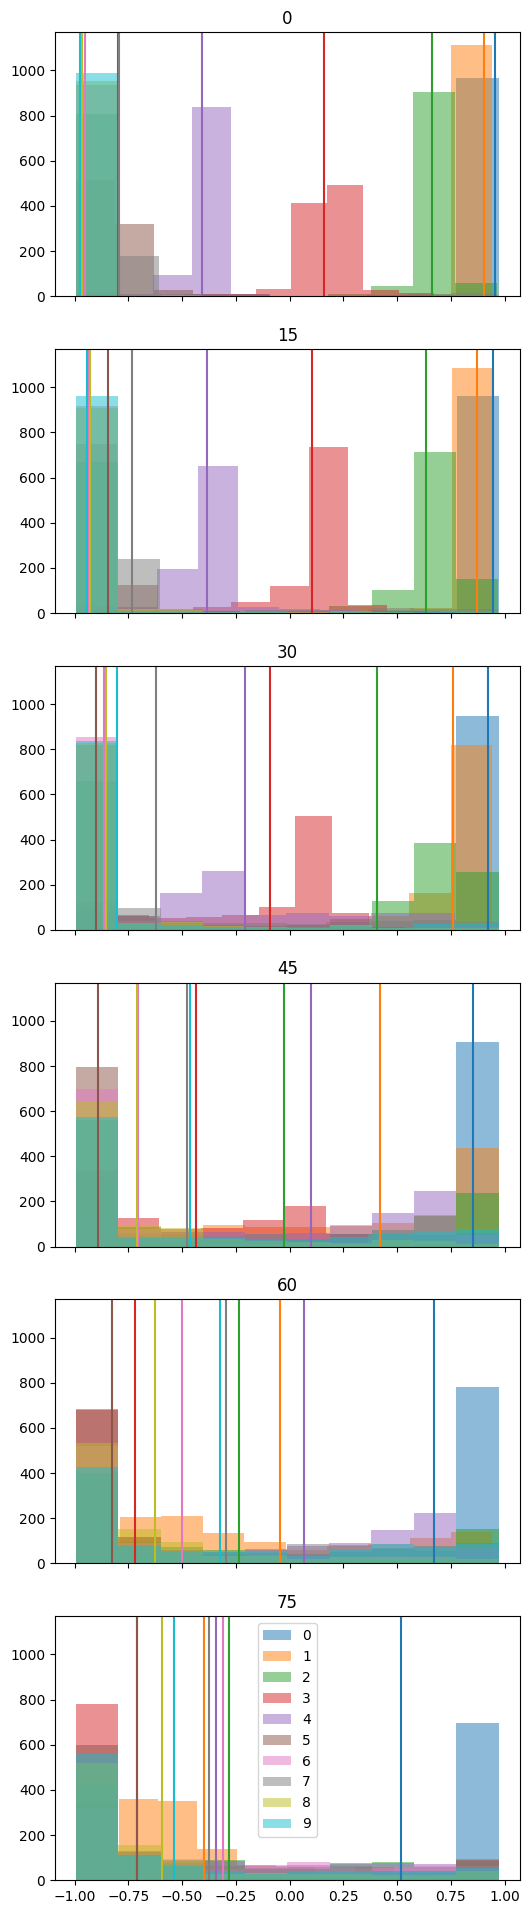

In [6]:
f, axs = plt.subplots(len(rotations), 1, sharey=True, sharex=True, figsize=(6,4*len(rotations)))

representation_idx = 2
for i in range(len(rotations)):
    rotation = rotations[i]
    qs, z = get_model_outputs(state, test_ds['image'+str(rotation)], test_ds['label'])

    digits = [_ for _ in range(10)]
    axs[i].set_title(str(rotation))
    for digit in digits:
        representations = jnp.asarray(z)[np.where(test_ds['label']==digit)]
        axs[i].hist(representations[:, representation_idx], label = str(digit), alpha=0.5)
        axs[i].axvline(x = np.mean(representations[:, representation_idx]), c = 'C'+str(digit))
axs[i].legend()